#Import&Installs

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 3.6 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=cbb243840499b57b5adb04ec82b9e2e2b431b33567368331d7e92d50d46f704e
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
import json
import pyspark
from pyspark.sql import SparkSession
from itertools import combinations
from pyspark.sql.functions import concat, col, lit, udf, split
import matplotlib.pyplot as plt
from pyspark.sql.types import *
from pyspark.ml.classification import FMClassifier
from pyspark.ml.clustering import KMeans, LDA, GaussianMixture, PowerIterationClustering
from pyspark.ml.evaluation import ClusteringEvaluator,  MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, Imputer , StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression, GBTClassifier, NaiveBayes, RandomForestClassifier, LinearSVC, OneVsRest

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
!pip install -U --no-cache-dir gdown --pre
!gdown "13YuvKWo-mC_YbTw0ztjcCz9_cQeU3G8G"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Downloading...
From: https://drive.google.com/uc?id=13YuvKWo-mC_YbTw0ztjcCz9_cQeU3G8G
To: /content/TestData.zip
100% 36.1M/36.1M [00:00<00:00, 90.1MB/s]


In [ ]:
!gdown "1--fu7x1CYHmU3KAn3M3nojb8_DXZ2ii9"

Downloading...
From: https://drive.google.com/uc?id=1--fu7x1CYHmU3KAn3M3nojb8_DXZ2ii9
To: /content/imdb-review-dataset.zip
100% 2.89G/2.89G [00:30<00:00, 96.0MB/s]


In [ ]:
!unzip 'TestData.zip'

Archive:  TestData.zip
  inflating: movies (1).json         
  inflating: movies.json             


In [ ]:
!unzip '/content/imdb-review-dataset.zip'

Archive:  /content/imdb-review-dataset.zip
  inflating: part-01.json            
  inflating: part-02.json            

#Create Spark Session

In [ ]:
spark = SparkSession \
    .builder \
    .appName('Movies Analysis') \
    .config("spark.driver.memory", "5g") \
    .getOrCreate()

#Load Data

In [ ]:
# Read JSON file into dataframe
Maindf = spark.read.json("/content/movies.json")

In [ ]:
Maindf.printSchema()

root
 |-- _corrupt_record: string (nullable = true)
 |-- adult: boolean (nullable = true)
 |-- backdrop_path: string (nullable = true)
 |-- belongs_to_collection: struct (nullable = true)
 |    |-- backdrop_path: string (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- poster_path: string (nullable = true)
 |-- budget: long (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- name: string (nullable = true)
 |-- homepage: string (nullable = true)
 |-- id: long (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- production_companies: array (nullable = true)
 |    |-- element: struct (containsNull = tru

In [ ]:
Maindf.show(5)

+--------------------+-----+--------------------+---------------------+--------+--------------------+--------------------+----+---------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+------------+--------+-------+--------------------+--------+--------------------+--------------------+-----+------------+----------+
|     _corrupt_record|adult|       backdrop_path|belongs_to_collection|  budget|              genres|            homepage|  id|  imdb_id|original_language|      original_title|            overview|popularity|         poster_path|production_companies|production_countries|release_date| revenue|runtime|    spoken_languages|  status|             tagline|               title|video|vote_average|vote_count|
+--------------------+-----+--------------------+---------------------+--------+--------------------+--------------------+----+---------+-----------------+--------------------+----------------

In [ ]:
Maindf.count()

70250

#Analyses TMDb Dataset

In [ ]:
!rm -r    '/content/AnalysisResults'
!mkdir    '/content/AnalysisResults'

rm: cannot remove '/content/AnalysisResults': No such file or directory


In [ ]:
savePath='/content/AnalysisResults/'
#total number of rows
df = Maindf
df_count = df.count()
print(df_count)

70250


##Movie Period & Avg Rate

In [ ]:
# select the needed columns
voteAvgAndPeriod=df.select(["vote_average","runtime"])
voteAvgAndPeriod = voteAvgAndPeriod.withColumn('vote_average/runtime', concat(col('runtime'),lit(','),col('vote_average')))
voteAvgAndPeriod = voteAvgAndPeriod.select(["vote_average/runtime"])
voteAvgAndPeriod.show(2)

+--------------------+
|vote_average/runtime|
+--------------------+
|                null|
|            74,7.274|
+--------------------+
only showing top 2 rows



In [ ]:
voteAvgAndPeriodRates = voteAvgAndPeriod.rdd.flatMap(lambda x:x)\
          .filter(lambda movie: movie != None) \
          .map(lambda movie:(movie.split(',')[0],(float(movie.split(',')[1]),1))) \
          .reduceByKey(lambda m1,m2:(m1[0]+m2[0],m1[1]+m2[1])) \
          .map(lambda movie:(movie[0],round((movie[1][0]/movie[1][1]),2)))\
          .sortBy(lambda movie: movie[1],ascending=False)\
          .collect()

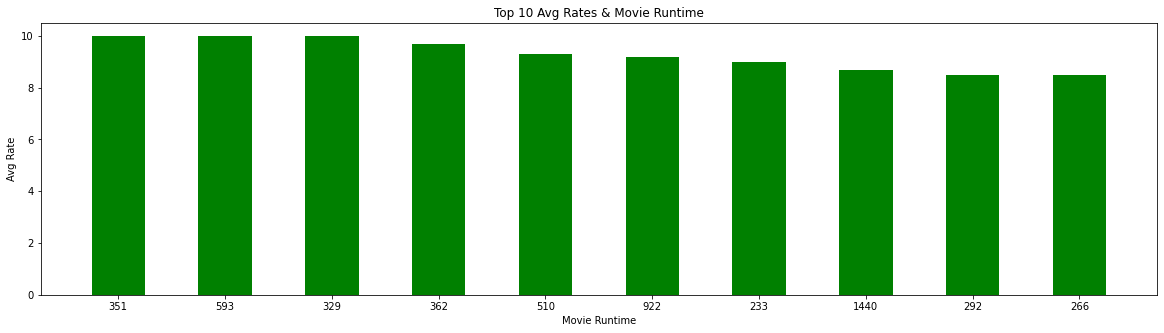

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(voteAvgAndPeriodRates)
keys = list(data.keys())[:10]
values = list(data.values())[:10]
fig, ax  = plt.subplots(figsize=(20,5))
plt.bar(keys, values,color=['green'],width = 0.5)
ax.set_ylabel('Avg Rate')
ax.set_xlabel('Movie Runtime')
plt.title("Top 10 Avg Rates & Movie Runtime")
plt.show()
plt.savefig(savePath+'Top 10 Avg Rates & Movie Runtime.png')

##Movie Type & Avg Rate

In [ ]:
# we need to change the form of genres to be able to manipulate with ardd operations
def TurntoGenres(genres):
  if genres != None:
    return ",".join([genre[1] for genre in genres])
MyFunc = udf(lambda x:TurntoGenres(x),StringType()) 

In [ ]:
testdf = Maindf.withColumn("genres", MyFunc(Maindf['genres']))

In [ ]:
testdf.show(3)

+--------------------+-----+--------------------+---------------------+-------+--------------------+--------------------+----+---------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+------------+-------+-------+--------------------+--------+--------------------+-------------------+-----+------------+----------+
|     _corrupt_record|adult|       backdrop_path|belongs_to_collection| budget|              genres|            homepage|  id|  imdb_id|original_language|      original_title|            overview|popularity|         poster_path|production_companies|production_countries|release_date|revenue|runtime|    spoken_languages|  status|             tagline|              title|video|vote_average|vote_count|
+--------------------+-----+--------------------+---------------------+-------+--------------------+--------------------+----+---------+-----------------+--------------------+--------------------+--

In [ ]:
#Since we made the data set we set the left team to be the one that won
voteAvgAndGenres = testdf.select(["vote_average","genres"])
voteAvgAndGenres = voteAvgAndGenres.withColumn('vote_average/genres', concat(col('vote_average'),lit('_'),col('genres')))
voteAvgAndGenres = voteAvgAndGenres.select(["vote_average/genres"])
voteAvgAndGenres.show(5,truncate = False)

+--------------------------+
|vote_average/genres       |
+--------------------------+
|null                      |
|7.274_Drama,Comedy,Romance|
|5.713_Crime,Comedy        |
|6.57_Action,Crime,Thriller|
|7.738_Documentary         |
+--------------------------+
only showing top 5 rows



In [ ]:
voteAvgAndGenresRates = voteAvgAndGenres.rdd.flatMap(lambda x:x)\
          .filter(lambda movie: movie != None) \
          .flatMap(lambda movie:[(genre,(float(movie.split('_')[0]),1)) for genre in movie.split('_')[1].split(',')]) \
          .reduceByKey(lambda m1,m2:(m1[0]+m2[0],m1[1]+m2[1])) \
          .map(lambda movie:(movie[0],round((movie[1][0]/movie[1][1]),2)))\
          .sortBy(lambda movie: movie[1],ascending=False)\
          .filter(lambda movie: movie[0] != '') \
          .collect()

voteAvgAndGenresRates

[('History', 6.11),
 ('War', 6.07),
 ('Fantasy', 5.79),
 ('Crime', 5.78),
 ('Animation', 5.77),
 ('Drama', 5.74),
 ('Mystery', 5.73),
 ('Adventure', 5.69),
 ('Romance', 5.66),
 ('TV Movie', 5.63),
 ('Family', 5.62),
 ('Comedy', 5.55),
 ('Western', 5.46),
 ('Music', 5.46),
 ('Thriller', 5.44),
 ('Action', 5.4),
 ('Science Fiction', 5.28),
 ('Documentary', 5.24),
 ('Horror', 4.91)]

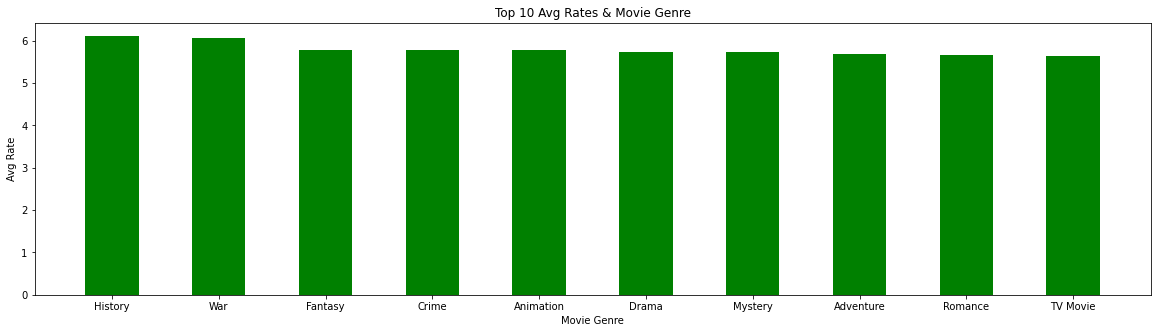

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(voteAvgAndGenresRates)
keys = list(data.keys())[:10]
values = list(data.values())[:10]
fig, ax  = plt.subplots(figsize=(20,5))
plt.bar(keys, values,color=['green'],width = 0.5)
ax.set_ylabel('Avg Rate')
ax.set_xlabel('Movie Genre')
plt.title("Top 10 Avg Rates & Movie Genre")
plt.show()
plt.savefig(savePath+'Top 10 Avg Rates & Movie Genre.png')

##Movie Type & Watch Rate

the amount of watchers could be estimated with the vote count for each movie.

In [ ]:
#Since we made the data set we set the left team to be the one that won
voteCountAndGenres = testdf.select(["vote_count","genres"])
voteCountAndGenres = voteCountAndGenres.withColumn('vote_count/genres', concat(col('vote_count'),lit('_'),col('genres')))
voteCountAndGenres = voteCountAndGenres.select(["vote_count/genres"])
voteCountAndGenres.show(5,truncate = False)

+-------------------------+
|vote_count/genres        |
+-------------------------+
|null                     |
|208_Drama,Comedy,Romance |
|2280_Crime,Comedy        |
|272_Action,Crime,Thriller|
|21_Documentary           |
+-------------------------+
only showing top 5 rows



In [ ]:
voteCountAvgAndGenres = voteCountAndGenres.rdd.flatMap(lambda x:x)\
          .filter(lambda movie: movie != None) \
          .flatMap(lambda movie:[(genre,(int(movie.split('_')[0]),1)) for genre in movie.split('_')[1].split(',')]) \
          .reduceByKey(lambda m1,m2:(m1[0]+m2[0],m1[1]+m2[1])) \
          .map(lambda movie:(movie[0],round((movie[1][0]/movie[1][1]),2)))\
          .sortBy(lambda movie: movie[1],ascending=False)\
          .filter(lambda movie: movie[0] != '') \
          .collect()

voteCountAvgAndGenres

[('Adventure', 678.15),
 ('Fantasy', 600.34),
 ('Science Fiction', 530.75),
 ('Action', 387.48),
 ('Family', 348.52),
 ('Thriller', 326.71),
 ('Mystery', 311.99),
 ('Animation', 302.95),
 ('Crime', 294.93),
 ('War', 231.54),
 ('History', 204.57),
 ('Romance', 191.06),
 ('Comedy', 181.5),
 ('Drama', 179.12),
 ('Horror', 174.23),
 ('Western', 141.45),
 ('Music', 50.71),
 ('TV Movie', 42.09),
 ('Documentary', 17.21)]

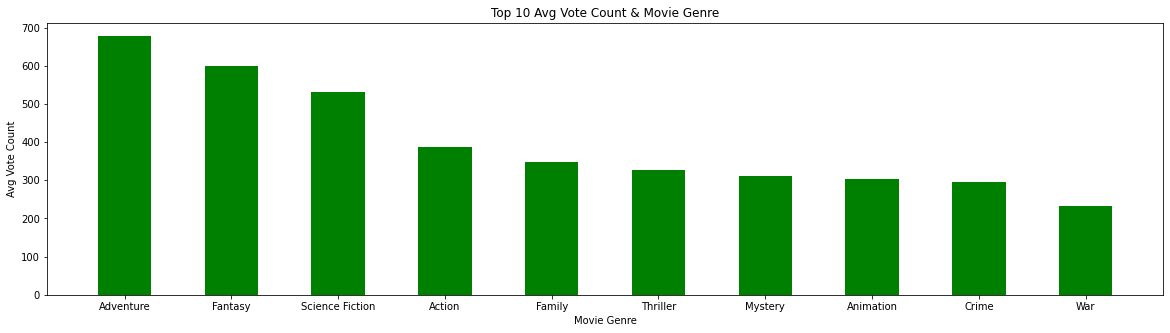

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(voteCountAvgAndGenres)
keys = list(data.keys())[:10]
values = list(data.values())[:10]
fig, ax  = plt.subplots(figsize=(20,5))
plt.bar(keys, values,color=['green'],width = 0.5)
ax.set_ylabel('Avg Vote Count')
ax.set_xlabel('Movie Genre')
plt.title("Top 10 Avg Vote Count & Movie Genre")
plt.show()
plt.savefig(savePath+'Top 10 Avg Vote Count & Movie Genre.png')

## Certain words in Title and Avg Rate

In [ ]:
#Since we made the data set we set the left team to be the one that won
voteAvgAndTitle = testdf.select(["vote_average","title"])
voteAvgAndTitle = voteAvgAndTitle.withColumn('vote_average/title', concat(col('vote_average'),lit('_'),col('title')))
voteAvgAndTitle = voteAvgAndTitle.select(["vote_average/title"])
voteAvgAndTitle.show(5,truncate = False)

+--------------------------------------+
|vote_average/title                    |
+--------------------------------------+
|null                                  |
|7.274_Shadows in Paradise             |
|5.713_Four Rooms                      |
|6.57_Judgment Night                   |
|7.738_Life in Loops (A Megacities RMX)|
+--------------------------------------+
only showing top 5 rows



In [ ]:
import re
voteAvgAndWords = voteAvgAndTitle.rdd.flatMap(lambda x:x)\
          .filter(lambda movie: movie != None) \
          .flatMap(lambda movie:[(re.sub('\W+','', word),(float(movie.split('_')[0]),1)) for word in movie.split('_')[1].split(' ')]) \
          .reduceByKey(lambda m1,m2:(m1[0]+m2[0],m1[1]+m2[1])) \
          .map(lambda movie:(movie[0],round((movie[1][0]/movie[1][1]),2)))\
          .sortBy(lambda movie: movie[1],ascending=False)\
          .filter(lambda movie: movie[0] != '') \
          .collect()

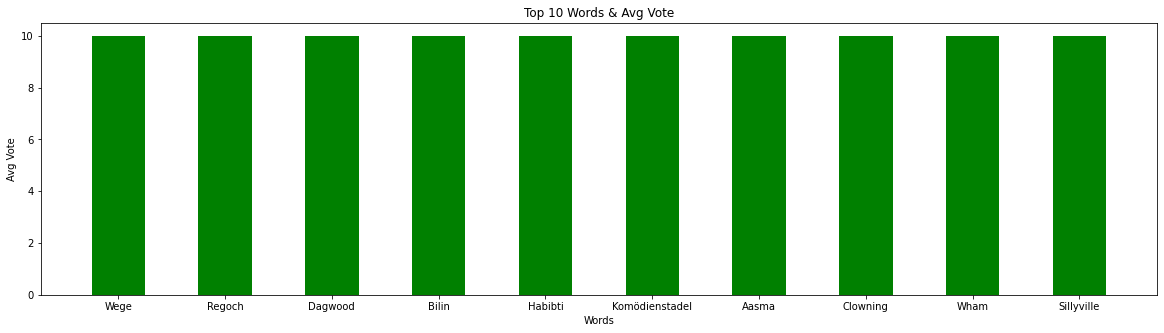

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(voteAvgAndWords)
keys = list(data.keys())[:10]
values = list(data.values())[:10]
fig, ax  = plt.subplots(figsize=(20,5))
plt.bar(keys, values,color=['green'],width = 0.5)
ax.set_ylabel('Avg Vote')
ax.set_xlabel('Words')
plt.title("Top 10 Words & Avg Vote")
plt.show()
plt.savefig(savePath+'Top 10 Words & Avg Vote.png')

## Movie Investing & Production Country

In [ ]:
# we need to change the form of Production Country to be able to manipulate with rdd operations
def TurntoCountries(production_countries):
  if production_countries != None:
    return ",".join([Country[1] for Country in production_countries])
MyFunc = udf(lambda x:TurntoCountries(x),StringType()) 

In [ ]:
testdf = Maindf.withColumn("production_countries", MyFunc(Maindf['production_countries']))

In [ ]:
testdf.show(3)

+--------------------+-----+--------------------+---------------------+-------+--------------------+--------------------+----+---------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+------------+-------+-------+--------------------+--------+--------------------+-------------------+-----+------------+----------+
|     _corrupt_record|adult|       backdrop_path|belongs_to_collection| budget|              genres|            homepage|  id|  imdb_id|original_language|      original_title|            overview|popularity|         poster_path|production_companies|production_countries|release_date|revenue|runtime|    spoken_languages|  status|             tagline|              title|video|vote_average|vote_count|
+--------------------+-----+--------------------+---------------------+-------+--------------------+--------------------+----+---------+-----------------+--------------------+--------------------+--

In [ ]:
#we select the production countries
production_countries = testdf.select(["production_countries"])
production_countries.show(5,truncate = False)

+------------------------+
|production_countries    |
+------------------------+
|null                    |
|Finland                 |
|United States of America|
|United States of America|
|Austria                 |
+------------------------+
only showing top 5 rows



In [ ]:
productionCountriesCount = production_countries.rdd.flatMap(lambda x:x)\
          .filter(lambda movie: movie != None) \
          .flatMap(lambda movie:[(Country,1) for Country in movie.split(',')]) \
          .reduceByKey(lambda m1,m2:m1+m2) \
          .map(lambda movie:(movie[0],round((movie[1]/df_count)*100,2)))\
          .sortBy(lambda movie: movie[1],ascending=False)\
          .filter(lambda movie: movie[0] != '') \
          .collect()

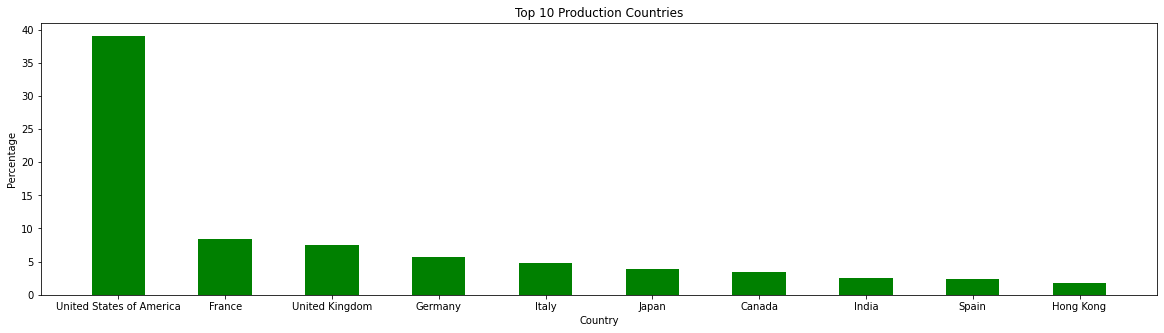

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(productionCountriesCount)
keys = list(data.keys())[:10]
values = list(data.values())[:10]
fig, ax  = plt.subplots(figsize=(20,5))
plt.bar(keys, values,color=['green'],width = 0.5)
ax.set_ylabel('Percentage')
ax.set_xlabel('Country')
plt.title("Top 10 Production Countries")
plt.show()
plt.savefig(savePath+'Top 10 Production Countries.png')

## Genre Pair Count

In [ ]:
# we need to change the form of genres to be able to manipulate with ardd operations
def TurntoGenres(genres):
  if genres != None:
    return ",".join([genre[1] for genre in genres])
MyFunc = udf(lambda x:TurntoGenres(x),StringType()) 

In [ ]:
Genres = Maindf.withColumn("genres", MyFunc(Maindf['genres']))# we need Genres only
Genres = Genres.select(["genres"])
Genres.show(5,truncate = False)

+---------------------+
|genres               |
+---------------------+
|null                 |
|Drama,Comedy,Romance |
|Crime,Comedy         |
|Action,Crime,Thriller|
|Documentary          |
+---------------------+
only showing top 5 rows



In [ ]:
def GetGenreCombinations(string):
    Genres = string.split(',')
    # if the genre is mentioned alone add None to see if some Genres come alone
    if len(Genres)==1:
      Genres.append("None")
    #sort the Genres to avoid tuples that contain the same two Genres but in different order
    Genres.sort()
    #return the combinations of Genres
    return list(combinations(Genres, 2))

In [ ]:
GenresPairs = Genres.rdd.flatMap(lambda x:x)\
          .filter(lambda movie: movie != None and movie != '' ) \
          .map(lambda champList:GetGenreCombinations(champList)) \
          .flatMap(lambda pair:pair) \
          .map(lambda pair:(pair,2)) \
          .reduceByKey(lambda pair1,pair2:pair1+pair2) \
          .sortBy(lambda pair:pair[1],ascending=False) \
          .collect()

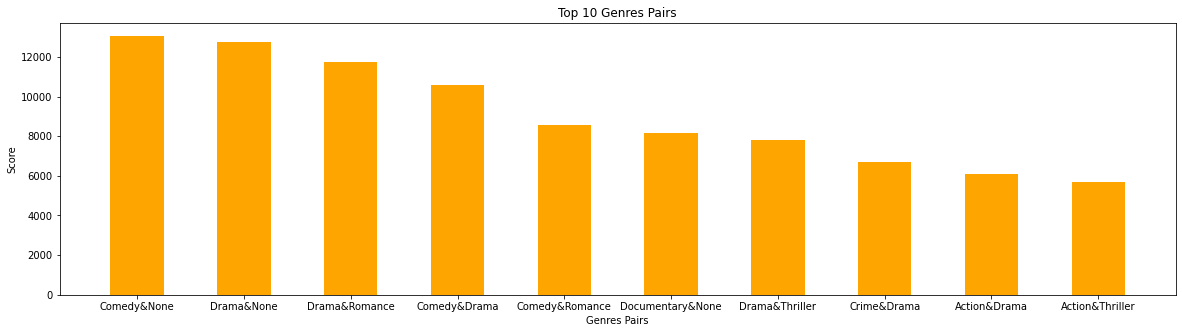

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(GenresPairs)
pairs = list(data.keys())[:10]
keys = ['&'.join(pair) for pair in pairs]
values = list(data.values())[:10]
fig, ax  = plt.subplots(figsize=(20,5))
plt.bar(keys, values,color=['orange'],width = 0.5)
ax.set_ylabel('Score')
ax.set_xlabel('Genres Pairs')
plt.title("Top 10 Genres Pairs")
plt.show()
plt.savefig(savePath+'Top 10 Genres Pairs.png')

## Most Spoken Languages

In [ ]:
# we need to change the form of spoken_languages to be able to manipulate with rdd operations
def TurntoLangs(Langs):
  if Langs != None:
    return ",".join([lang[0] for lang in Langs])
MyFunc = udf(lambda x:TurntoLangs(x),StringType()) 

In [ ]:
testdf = Maindf.withColumn("spoken_languages", MyFunc(Maindf['spoken_languages']))

In [ ]:
testdf.show(3)

+--------------------+-----+--------------------+---------------------+-------+--------------------+--------------------+----+---------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+------------+-------+-------+--------------------+--------+--------------------+-------------------+-----+------------+----------+
|     _corrupt_record|adult|       backdrop_path|belongs_to_collection| budget|              genres|            homepage|  id|  imdb_id|original_language|      original_title|            overview|popularity|         poster_path|production_companies|production_countries|release_date|revenue|runtime|    spoken_languages|  status|             tagline|              title|video|vote_average|vote_count|
+--------------------+-----+--------------------+---------------------+-------+--------------------+--------------------+----+---------+-----------------+--------------------+--------------------+--

In [ ]:
#we select the production countries
SpokenLanguages = testdf.select(["spoken_languages"])
SpokenLanguages.show(5,truncate = False)

+--------------------------------------+
|spoken_languages                      |
+--------------------------------------+
|null                                  |
|Swedish,Finnish,English               |
|English                               |
|English                               |
|English,Hindi,Japanese,Russian,Spanish|
+--------------------------------------+
only showing top 5 rows



In [ ]:
mostSpokenLanguages = SpokenLanguages.rdd.flatMap(lambda x:x)\
          .filter(lambda movie: movie != None) \
          .flatMap(lambda movie:[(lang,1) for lang in movie.split(',')]) \
          .reduceByKey(lambda l1,l2:l1+l2) \
          .map(lambda lang:(lang[0],round((lang[1]/df_count)*100,2)))\
          .sortBy(lambda lang: lang[1],ascending=False)\
          .filter(lambda lang: lang[0] != '') \
          .collect()

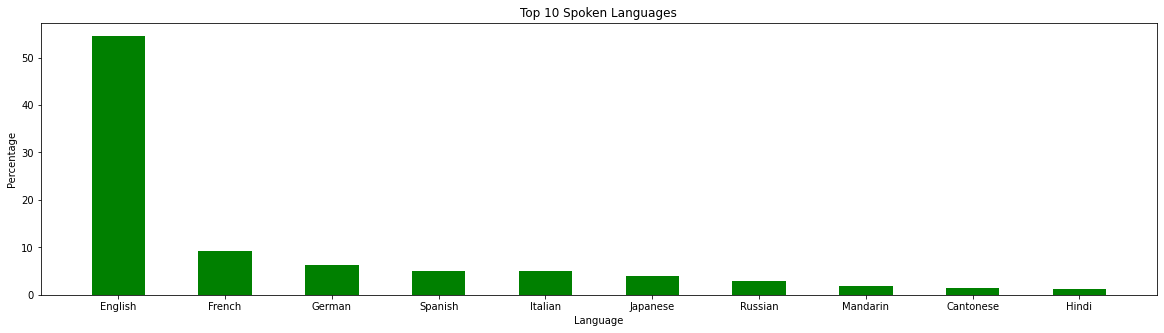

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(mostSpokenLanguages)
keys = list(data.keys())[:10]
values = list(data.values())[:10]
fig, ax  = plt.subplots(figsize=(20,5))
plt.bar(keys, values,color=['green'],width = 0.5)
ax.set_ylabel('Percentage')
ax.set_xlabel('Language')
plt.title("Top 10 Spoken Languages")
plt.show()
plt.savefig(savePath+'Top 10 Spoken Languages.png')

## Adult Film Percent

In [ ]:
AdultFlag = Maindf.select(['adult'])

In [ ]:
AdultFlag.show(3)

+-----+
|adult|
+-----+
| null|
|false|
|false|
+-----+
only showing top 3 rows



In [ ]:
AdultFlagCount = AdultFlag.rdd.flatMap(lambda x:x)\
          .filter(lambda movie: movie != None) \
          .map(lambda movie:(str(movie),1)) \
          .reduceByKey(lambda l1,l2:l1+l2) \
          .map(lambda movie:( movie[0],round(( movie[1]/df_count)*100,2)))\
          .sortBy(lambda movie:  movie[1],ascending=False)\
          .filter(lambda movie:  movie[0] != '') \
          .collect()

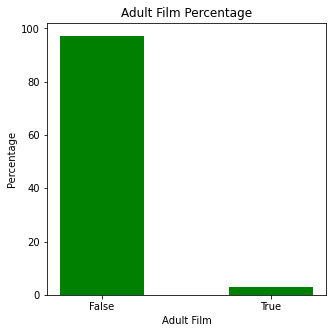

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(AdultFlagCount)
keys = list(data.keys())[:10]
values = list(data.values())[:10]
fig, ax  = plt.subplots(figsize=(5,5))
plt.bar(keys, values,color=['green'],width = 0.5)
ax.set_ylabel('Percentage')
ax.set_xlabel('Adult Film')
plt.title("Adult Film Percentage")
plt.show()
plt.savefig(savePath+'Adult Film Percentage.png')

## Certain words in Overview and Avg Rate

In [ ]:
#Since we made the data set we set the left team to be the one that won
voteAvgAndOverview = testdf.select(["vote_average","overview"])
voteAvgAndOverview = voteAvgAndOverview.withColumn('vote_average/overview', concat(col('vote_average'),lit('_'),col('overview')))
voteAvgAndOverview = voteAvgAndOverview.select(["vote_average/overview"])
voteAvgAndOverview.show(5,truncate = False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|vote_average/overview              

In [ ]:
import re
voteAvgAndWordsInOverview = voteAvgAndOverview.rdd.flatMap(lambda x:x)\
          .filter(lambda movie: movie != None) \
          .flatMap(lambda movie:[(re.sub('\W+','', word),(float(movie.split('_')[0]),1)) for word in movie.split('_')[1].split(' ')]) \
          .reduceByKey(lambda m1,m2:(m1[0]+m2[0],m1[1]+m2[1])) \
          .map(lambda movie:(movie[0],round((movie[1][0]/movie[1][1]),2)))\
          .sortBy(lambda movie: movie[1],ascending=False)\
          .filter(lambda movie: movie[0] != '') \
          .collect()

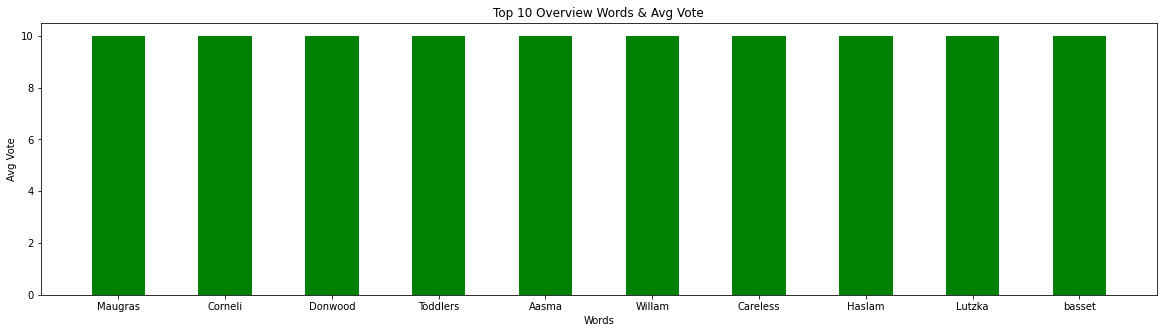

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(voteAvgAndWordsInOverview )
keys = list(data.keys())[:10]
values = list(data.values())[:10]
fig, ax  = plt.subplots(figsize=(20,5))
plt.bar(keys, values,color=['green'],width = 0.5)
ax.set_ylabel('Avg Vote')
ax.set_xlabel('Words')
plt.title("Top 10 Overview Words & Avg Vote")
plt.show()
plt.savefig(savePath+'Top 10 Overview Words & Avg Vote.png')

#Analyses IMDb Review Dataset 

In [ ]:
# Read JSON file into dataframe
revdf = spark.read.json("/content/sample.json")

In [ ]:
revdf.printSchema()

root
 |-- helpful: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- movie: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- review_date: string (nullable = true)
 |-- review_detail: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- review_summary: string (nullable = true)
 |-- reviewer: string (nullable = true)
 |-- spoiler_tag: long (nullable = true)



In [ ]:
revdf.show(5)

+--------+--------------------+------+------------+--------------------+---------+--------------------+-------------------+-----------+
| helpful|               movie|rating| review_date|       review_detail|review_id|      review_summary|           reviewer|spoiler_tag|
+--------+--------------------+------+------------+--------------------+---------+--------------------+-------------------+-----------+
|  [0, 1]|Kill Bill: Vol. 2...|     8|24 July 2005|After seeing Tara...|rw1133942|Good follow up th...|OriginalMovieBuff21|          0|
|[11, 11]|Journey to the Un...|  null|24 July 2005|I have the entire...|rw1133943|    Excellent series|           sentra14|          0|
|  [2, 5]|   The Island (2005)|     9|24 July 2005|Once again the cr...|rw1133946|Not just about ac...|  GreenwheelFan2002|          0|
|  [2, 3]|Win a Date with T...|     3|24 July 2005|This IS a film th...|rw1133948|Falls under the c...|     itsascreambaby|          0|
|  [4, 4]|Saturday Night Li...|    10|24 July 20

In [ ]:
!rm -r    '/content/AnalysisResults_IMDb'
!mkdir    '/content/AnalysisResults_IMDb'

rm: cannot remove '/content/AnalysisResults_IMDb': No such file or directory


In [ ]:
savePath='/content/AnalysisResults_IMDb/'
df_count = revdf.count()
print(df_count)

100000


## Most Reviewing Users

In [ ]:
reviewers = revdf.select(['reviewer'])

In [ ]:
reviewers.show(3)

+-------------------+
|           reviewer|
+-------------------+
|OriginalMovieBuff21|
|           sentra14|
|  GreenwheelFan2002|
+-------------------+
only showing top 3 rows



In [ ]:
reviewersCount = reviewers.rdd.flatMap(lambda x:x)\
          .filter(lambda reviewer:reviewer != None) \
          .map(lambda reviewer:(reviewer,1)) \
          .reduceByKey(lambda r1,r2:r1+r2) \
          .map(lambda reviewer:( reviewer[0], reviewer[1]))\
          .sortBy(lambda reviewer:  reviewer[1],ascending=False)\
          .filter(lambda reviewer:  reviewer[0] != '') \
          .collect()

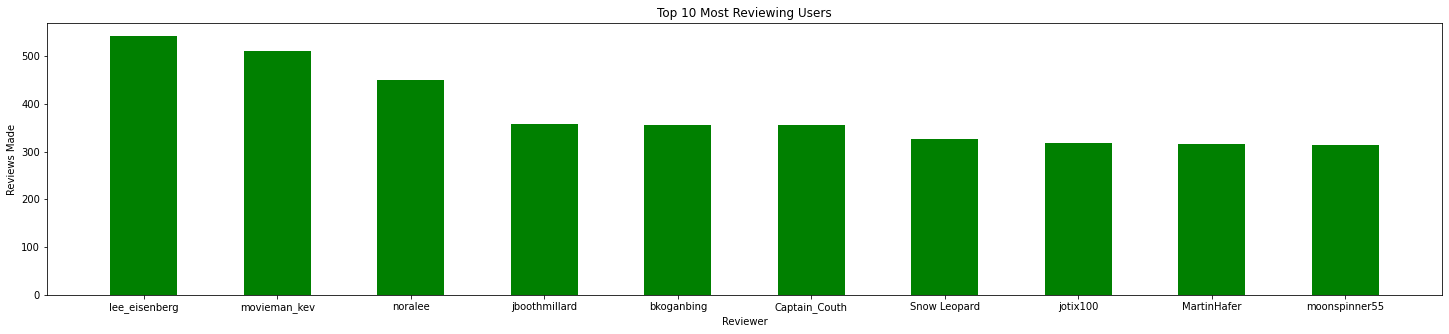

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(reviewersCount)
keys = list(data.keys())[:10]
values = list(data.values())[:10]
fig, ax  = plt.subplots(figsize=(25,5))
plt.bar(keys, values,color=['green'],width = 0.5)
ax.set_ylabel('Reviews Made')
ax.set_xlabel('Reviewer')
plt.title("Top 10 Most Reviewing Users")
plt.show()
plt.savefig(savePath+'Top 10 Most Reviewing Users.png')

## Most helpful reviewers

In [ ]:
reviews = revdf.select(['reviewer', 'helpful'])
reviews.show(5)

+-------------------+--------+
|           reviewer| helpful|
+-------------------+--------+
|OriginalMovieBuff21|  [0, 1]|
|           sentra14|[11, 11]|
|  GreenwheelFan2002|  [2, 5]|
|     itsascreambaby|  [2, 3]|
|OriginalMovieBuff21|  [4, 4]|
+-------------------+--------+
only showing top 5 rows



In [ ]:
# Auxiliary function to check if a review is helpful
def is_helpful(h):
    try:
        if (float(h[0])/float(h[1])) > 0.5:
            return 1
        else:
            return 0
    except:
        return 0

In [ ]:
# Grabbing all helpful reviews out there
helpful_reviews = reviews.rdd \
          .map(lambda row:(row[0], is_helpful(row[1]))) \
          .reduceByKey(lambda r1,r2:r1+r2) \
          .sortBy(lambda row:  row[1],ascending=False).collect()

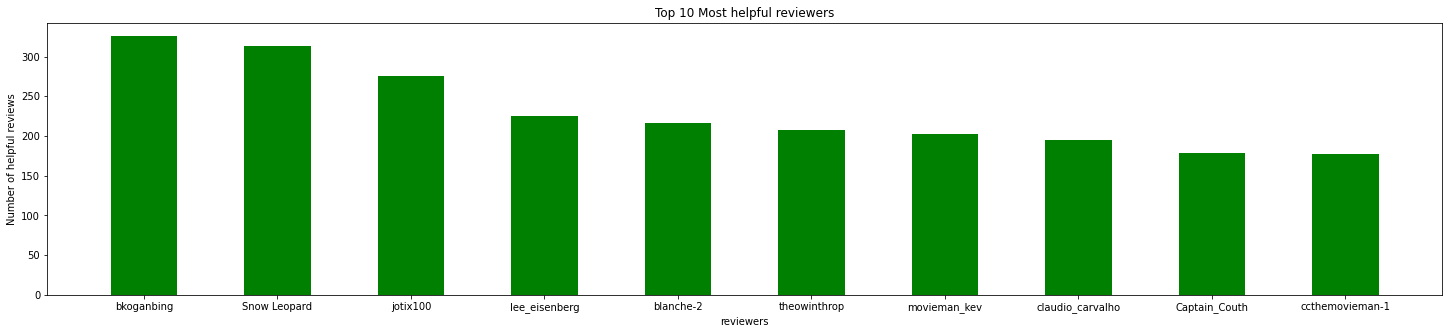

In [ ]:
data = dict(helpful_reviews)
keys = list(data.keys())[:10]
values = list(data.values())[:10]
fig, ax  = plt.subplots(figsize=(25,5))
plt.bar(keys, values,color=['green'],width = 0.5)
ax.set_ylabel('Number of helpful reviews')
ax.set_xlabel('reviewers')
plt.title("Top 10 Most helpful reviewers")
plt.show()

## Number of spoiler-tagged reviews per user

In [ ]:
reviewers = revdf.select(['reviewer', 'spoiler_tag'])
reviewers.show(5)

+-------------------+-----------+
|           reviewer|spoiler_tag|
+-------------------+-----------+
|OriginalMovieBuff21|          0|
|           sentra14|          0|
|  GreenwheelFan2002|          0|
|     itsascreambaby|          0|
|OriginalMovieBuff21|          0|
+-------------------+-----------+
only showing top 5 rows



In [ ]:
# Grabbing all helpful reviews out there
spoiler_reviewers = reviewers.rdd \
          .map(lambda row:(row[0], float(row[1]))) \
          .reduceByKey(lambda r1,r2:r1+r2) \
          .sortBy(lambda row:  row[1],ascending=False).collect()

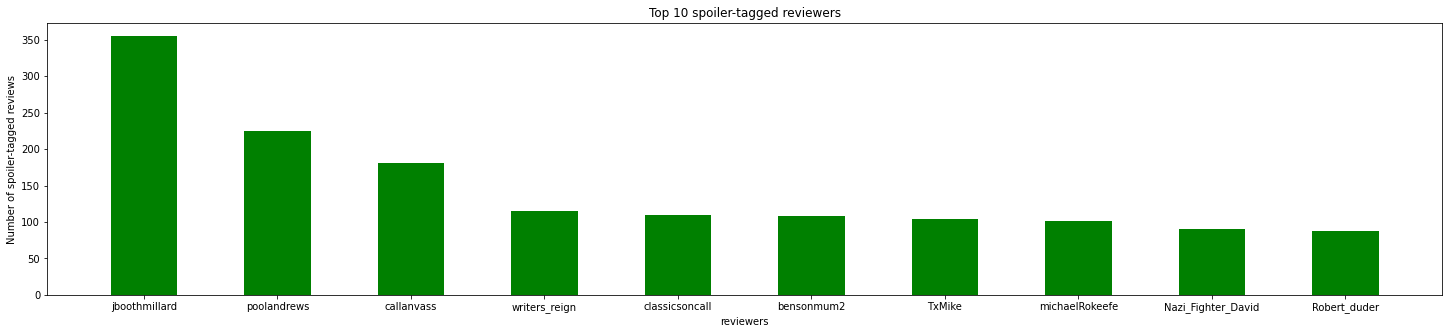

In [ ]:
data = dict(spoiler_reviewers)
keys = list(data.keys())[:10]
values = list(data.values())[:10]
fig, ax  = plt.subplots(figsize=(25,5))
plt.bar(keys, values,color=['green'],width = 0.5)
ax.set_ylabel('Number of spoiler-tagged reviews')
ax.set_xlabel('reviewers')
plt.title("Top 10 spoiler-tagged reviewers")
plt.show()

## Average rate per movie

In [ ]:
movies = revdf.select(['movie', 'rating'])
movies.show(5)

+--------------------+------+
|               movie|rating|
+--------------------+------+
|Kill Bill: Vol. 2...|     8|
|Journey to the Un...|  null|
|   The Island (2005)|     9|
|Win a Date with T...|     3|
|Saturday Night Li...|    10|
+--------------------+------+
only showing top 5 rows



In [ ]:
# function to turn the rating into float
def to_float(rating):
    try:
        return float(rating)
    except:
        return 0

In [ ]:
movies_rating = movies.rdd \
    .map(lambda row: (row[0], (to_float(row[1]), 1))) \
    .reduceByKey(lambda v1, v2:(v1[0]+v2[0], v1[1]+v2[1])) \
    .map(lambda row: (row[0], row[1][0]/row[1][1])) \
    .sortBy(lambda row:  row[1],ascending=True).collect()

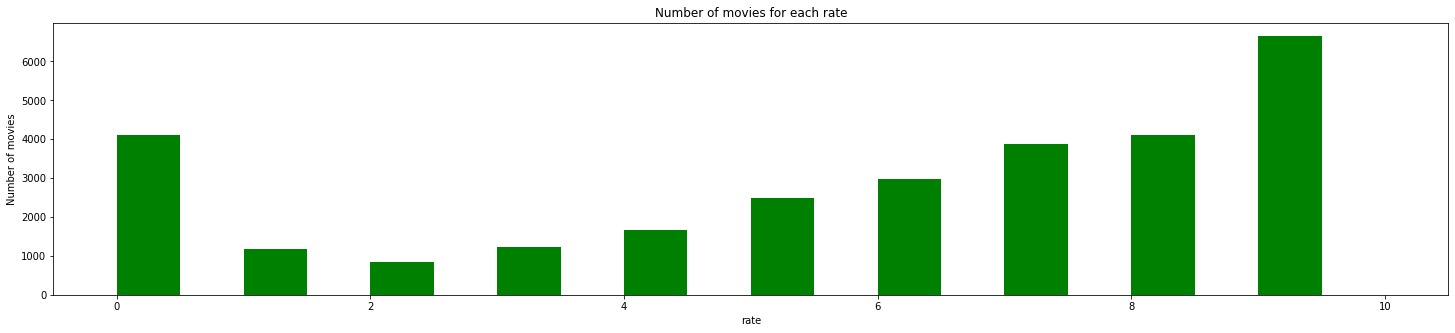

In [ ]:
# histogram of movies
data = dict(movies_rating)
keys = list(data.keys())
values = list(data.values())
fig, ax  = plt.subplots(figsize=(25,5))
plt.hist(values,color=['green'],width = 0.5)
ax.set_ylabel('Number of movies')
ax.set_xlabel('rate')
plt.title("Number of movies for each rate")
plt.show()

## Occurences of each movie as a favorite movie

In [ ]:
movies = revdf.select(['reviewer', 'movie', 'rating'])
movies.show(5)

+-------------------+--------------------+------+
|           reviewer|               movie|rating|
+-------------------+--------------------+------+
|OriginalMovieBuff21|Kill Bill: Vol. 2...|     8|
|           sentra14|Journey to the Un...|  null|
|  GreenwheelFan2002|   The Island (2005)|     9|
|     itsascreambaby|Win a Date with T...|     3|
|OriginalMovieBuff21|Saturday Night Li...|    10|
+-------------------+--------------------+------+
only showing top 5 rows



In [ ]:
# function to turn the rating into float
def to_float(rating):
    try:
        return float(rating)
    except:
        return 0

In [ ]:
user_movie = movies.rdd \
    .map(lambda row: (row[0], (row[1],to_float(row[2])))) \
    .reduceByKey(lambda r1,r2:r1 if r1[1] > r2[1] else r2) \
    .map(lambda row: (row[1][0], 1)) \
    .reduceByKey(lambda r1, r2: float(r1)+float(r2)) \
    .sortBy(lambda row:  row[1],ascending=False).collect()
    

In [ ]:
user_movie

[('Harry Potter and the Goblet of Fire (2005)', 1066.0),
 ('Serenity (2005)', 843.0),
 ('King Kong (2005)', 842.0),
 ('The Chronicles of Narnia: The Lion, the Witch and the Wardrobe (2005)',
  533.0),
 ('Charlie and the Chocolate Factory (2005)', 430.0),
 ('Rent (2005)', 349.0),
 ('A History of Violence (2005)', 329.0),
 ('Saw II (2005)', 322.0),
 ('Pride & Prejudice (2005)', 310.0),
 ('War of the Worlds (2005)', 306.0),
 ('The Dukes of Hazzard (2005)', 297.0),
 ('Doom (2005)', 288.0),
 ('Crash (I) (2004)', 257.0),
 ('Jarhead (2005)', 246.0),
 ('Brokeback Mountain (2005)', 245.0),
 ('Batman Begins (2005)', 235.0),
 ('The Island (2005)', 230.0),
 ("The Devil's Rejects (2005)", 226.0),
 ('The Brothers Grimm (2005)', 188.0),
 ('Final Fantasy VII: Advent Children (2005)', 179.0),
 ('Red Eye (2005)', 174.0),
 ('Walk the Line (2005)', 173.0),
 ('Sin City (2005)', 170.0),
 ('The Exorcism of Emily Rose (2005)', 163.0),
 ('Star Wars: Episode III - Revenge of the Sith (2005)', 162.0),
 ('Elizabe

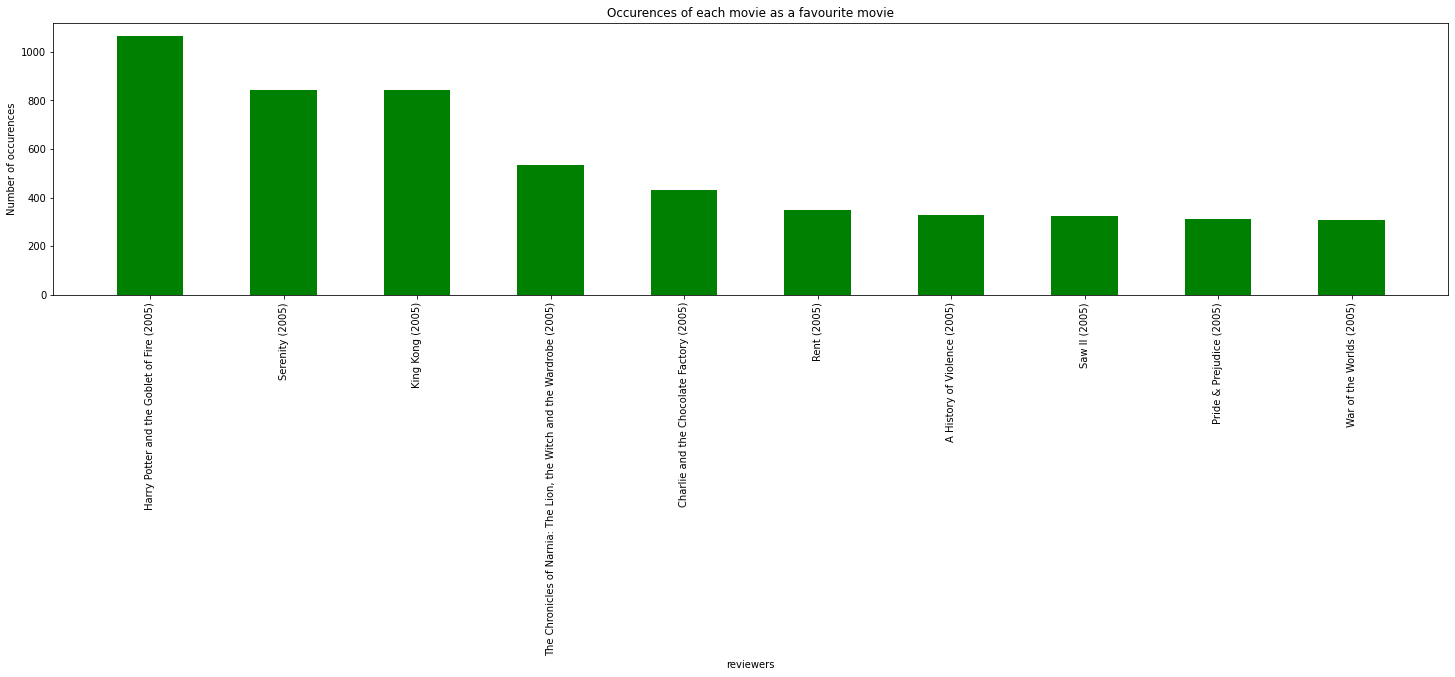

In [ ]:
# histogram of movies
data = dict(user_movie)
keys = list(data.keys())[0:10]
values = list(data.values())[0:10]
fig, ax  = plt.subplots(figsize=(25,5))
plt.bar(keys, values,color=['green'],width = 0.5)
ax.set_ylabel('Number of occurences')
ax.set_xlabel('reviewers')
plt.title("Occurences of each movie as a favourite movie")
plt.xticks(rotation=90)
plt.show()

##Polarity Of Reviews

In [ ]:
# select the needed columns

reviews = revdf.select(['movie',"review_detail"])
reviews = reviews.withColumn('movie/review_detail', concat(col('movie'),lit(','),col('review_detail')))
reviews = reviews.select(["movie/review_detail"])
reviews.show(2)

+--------------------+
| movie/review_detail|
+--------------------+
|Kill Bill: Vol. 2...|
|Journey to the Un...|
+--------------------+
only showing top 2 rows



In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
negPosReviews = reviews.rdd.flatMap(lambda x:x)\
          .filter(lambda movie: movie != None) \
          .map(lambda movie:(movie.split(',')[0], movie.split(',')[1])) \
          .map(lambda movie:(movie[0],sia.polarity_scores(movie[1]))) \
          .map(lambda movie:(movie[0],(movie[1]['pos'], movie[1]['neu']))) \
          .map(lambda movie:((movie[1][0]>=movie[1][1])*"Pos" +(movie[1][0]<movie[1][1])*"Neg",1))\
          .reduceByKey(lambda m1,m2:m1+m2)\
          .map(lambda movie:(movie[0],round(movie[1]/df_count,2)*100))\
          .collect()
negPosReviews

[('Neg', 94.0), ('Pos', 6.0)]

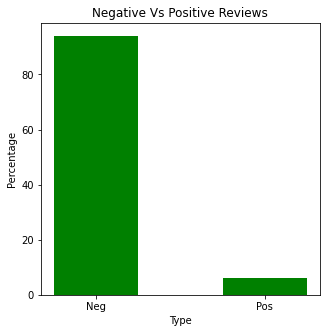

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(negPosReviews)
keys = list(data.keys())[:10]
values = list(data.values())[:10]
fig, ax  = plt.subplots(figsize=(5,5))
plt.bar(keys, values,color=['green'],width = 0.5)
ax.set_ylabel('Percentage')
ax.set_xlabel('Type')
plt.title("Negative Vs Positive Reviews")
plt.show()
plt.savefig(savePath+'Negative Vs Positive Reviews.png')

## Top 5 Movies with Positive Reviews

In [ ]:
posReviewsPerMovie = reviews.rdd.flatMap(lambda x:x)\
          .filter(lambda movie: movie != None) \
          .map(lambda movie:(movie.split(',')[0], movie.split(',')[1])) \
          .map(lambda movie:(movie[0],sia.polarity_scores(movie[1]))) \
          .map(lambda movie:(movie[0],(movie[1]['pos'],1))) \
          .reduceByKey(lambda m1,m2:(m1[0]+m2[0],m1[1]+m2[1]))\
          .map(lambda movie:(movie[0],movie[1][0]/movie[1][1]))\
          .sortBy(lambda movie: movie[1],ascending=False)\
          .collect()

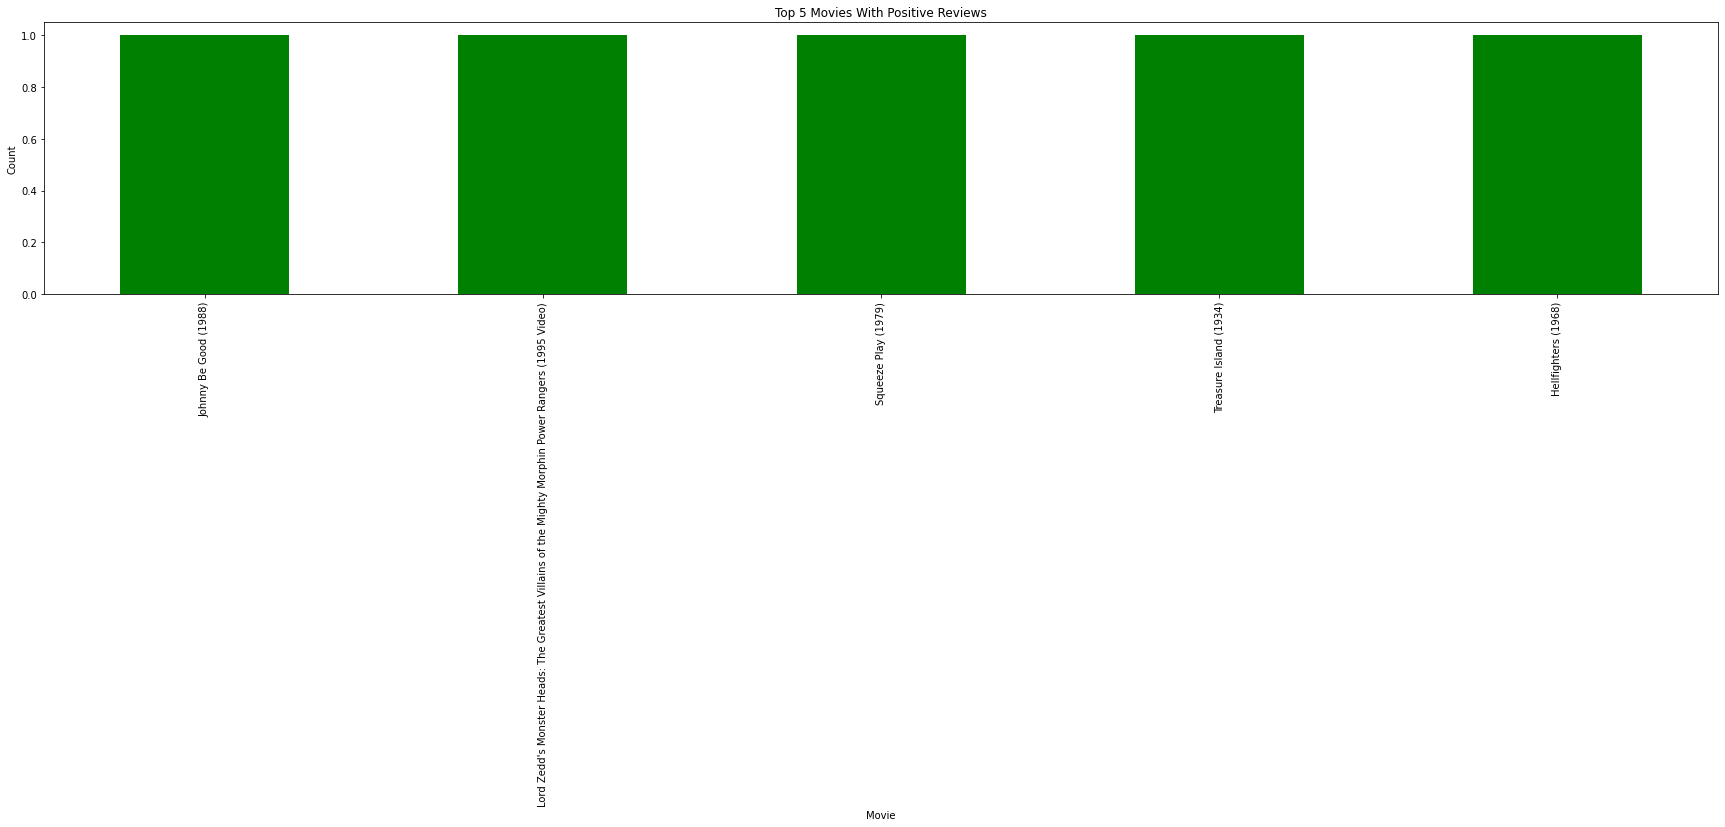

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(posReviewsPerMovie)
keys = list(data.keys())[:5]
values = list(data.values())[:5]
fig, ax  = plt.subplots(figsize=(30,5))
plt.bar(keys, values,color=['green'],width = 0.5)
ax.set_ylabel('Count')
ax.set_xlabel('Movie')
plt.title("Top 5 Movies With Positive Reviews")
plt.xticks(rotation=90)
plt.show()
plt.savefig(savePath+'Top 5 Movies With Positive Reviews.png')

## Top 5 Movies with Negative Reviews

In [ ]:
negReviewsPerMovie = reviews.rdd.flatMap(lambda x:x)\
          .filter(lambda movie: movie != None) \
          .map(lambda movie:(movie.split(',')[0], movie.split(',')[1])) \
          .map(lambda movie:(movie[0],sia.polarity_scores(movie[1]))) \
          .map(lambda movie:(movie[0],(movie[1]['neu'],1))) \
          .reduceByKey(lambda m1,m2:(m1[0]+m2[0],m1[1]+m2[1]))\
          .map(lambda movie:(movie[0],movie[1][0]/movie[1][1]))\
          .sortBy(lambda movie: movie[1],ascending=False)\
          .collect()

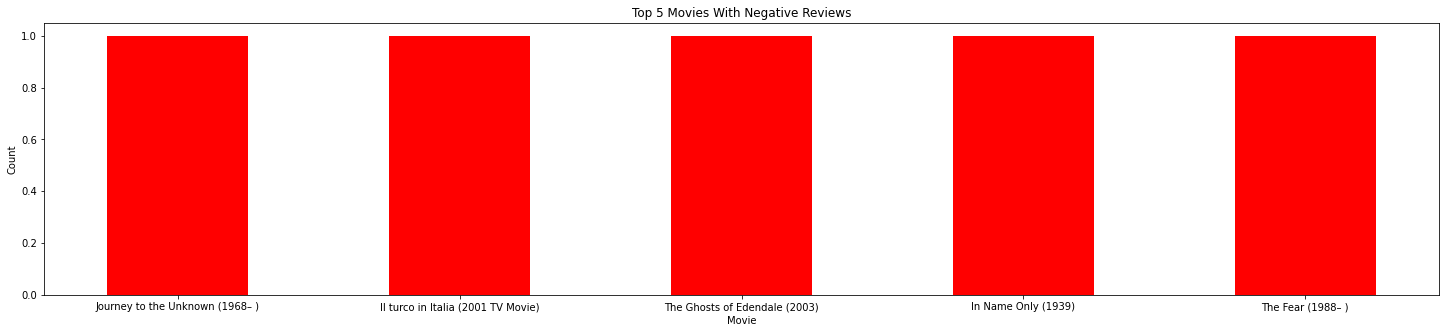

<Figure size 432x288 with 0 Axes>

In [ ]:
data = dict(negReviewsPerMovie)
keys = list(data.keys())[:5]
values = list(data.values())[:5]
fig, ax  = plt.subplots(figsize=(25,5))
plt.bar(keys, values,color=['red'],width = 0.5)
ax.set_ylabel('Count')
ax.set_xlabel('Movie')
plt.title("Top 5 Movies With Negative Reviews")
plt.show()
plt.savefig(savePath+'Top 5 Movies With Negative Reviews.png')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!zip '/content/part-01.json'

	zip warning: missing end signature--probably not a zip file (did you
	zip warning: remember to use binary mode when you transferred it?)
	zip warning: (if you are trying to read a damaged archive try -F)

zip error: Zip file structure invalid (/content/part-01.json)


In [ ]:
!zip -r /content/Data.zip /content/part-01.json

  adding: content/part-01.json (deflated 64%)


In [ ]:
import shutil

In [ ]:
shutil.move("/content/Data.zip", "/content/drive/MyDrive/BigData")

'/content/drive/MyDrive/BigData/Data.zip'